In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import rdkit.Chem as Chem
import datamol as dm

# Load data

In [2]:
ERed_data=pd.read_csv(r"../Data/Reduction_potential_213BzNSN.csv")
ERed_data.head()

,SMILES,Ered(V)
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,1.27
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,1.27
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.24
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.22
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.20


In [3]:
ERed_data.columns

Index(['SMILES', 'Ered(V)'], dtype='object')

# Data exploration

In [4]:
import matplotlib.pyplot as plt

In [5]:
ERed_data.describe()

,Ered(V)
count,1569.000000
mean,1.402199
std,0.171699
min,0.780000
25%,1.290000
50%,1.430000
75%,1.520000
max,1.870000


# Test Hypothesis
# Is ERed data normally distributed? 

In [6]:
print(f"Reduction potential (ERed) mean={ERed_data['Ered(V)'].mean():0.2f}, median={ERed_data['Ered(V)'].median():0.2f}, mode={ERed_data['Ered(V)'].mode()}")

Reduction potential (ERed) mean=1.40, median=1.43, mode=0    1.46
dtype: float64


*Characteristics of normal distribution*
- the mean, median, and mode all represent the center of the distribution 
- bell shape distribution
- almost 68%, 95% and 99.7% data falls within 1, 2, and 3 sigma, respectively

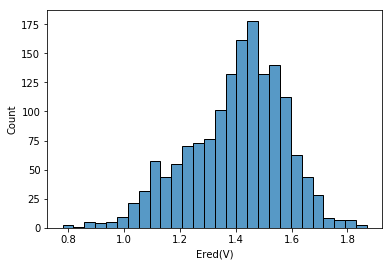

In [7]:
sns.histplot(ERed_data['Ered(V)'])

In [8]:
ERed_data['Ered(V)'].describe()

count    1569.000000
mean        1.402199
std         0.171699
min         0.780000
25%         1.290000
50%         1.430000
75%         1.520000
max         1.870000
Name: Ered(V), dtype: float64

**From the above plot we can see that ERed data is not normally distributed**

- *Linear regression assumes that errors or residuals follow a normal distribution*
- *Some ML algo like LDA and QDA inherently assume normally distributed data*

In [9]:
# Chebyshev rule
"""
at least 1−1/k² of the distribution’s values are within k standard deviations of the mean

A weaker three-sigma rule can be derived from Chebyshev's inequality, stating that even for non-normally distributed variables, at least 88.8% of cases should fall within properly calculated three-sigma intervals.
"""

Emean=ERed_data["Ered(V)"].mean()
Estd=ERed_data["Ered(V)"].std()

limit=Emean+1*Estd # 1*sigma
k=(limit-Emean)/Estd
print(f"Minimum %population within the 1*sigma = {100-100/(k*k):0.2f}")

limit=Emean+2*Estd # 2*sigma
k=(limit-Emean)/Estd
print(f"Minimum %population within the 2*sigma = {100-100/(k*k):0.2f}")

limit=Emean+3*Estd # 3*sigma
k=(limit-Emean)/Estd
print(f"Minimum %population within the 3*sigma = {100-100/(k*k):0.2f}")

limit=Emean+4*Estd # 3*sigma
k=(limit-Emean)/Estd
print(f"Minimum %population within the 4*sigma = {100-100/(k*k):0.2f}")


Minimum %population within the 1*sigma = 0.00
Minimum %population within the 2*sigma = 75.00
Minimum %population within the 3*sigma = 88.89
Minimum %population within the 4*sigma = 93.75


**We can confidently say that 75% of all data should fall within 2 standard deviations away from the mean**

*Characteristics of normal distribution*
- almost 68%, 95% and 99.7% data falls within 1, 2, and 3 sigma, respectively

In [10]:
pop_1sigma=sum(ERed_data["Ered(V)"].between(Emean-Estd,Emean+Estd,inclusive=True))
print(f"%population within the 1*sigma = {100*pop_1sigma/ERed_data.shape[0]:0.2f}")

pop_2sigma=sum(ERed_data["Ered(V)"].between(Emean-2*Estd,Emean+2*Estd,inclusive=True))
print(f"%population within the 2*sigma = {100*pop_2sigma/ERed_data.shape[0]:0.2f}")

pop_3sigma=sum(ERed_data["Ered(V)"].between(Emean-3*Estd,Emean+3*Estd,inclusive=True))
print(f"%population within the 3*sigma = {100*pop_3sigma/ERed_data.shape[0]:0.2f}")

%population within the 1*sigma = 68.20
%population within the 2*sigma = 95.92
%population within the 3*sigma = 99.55


*Not a perfect normal distribution*

Quantile-Quantile Plot

In [11]:
import pylab
import scipy.stats as stats

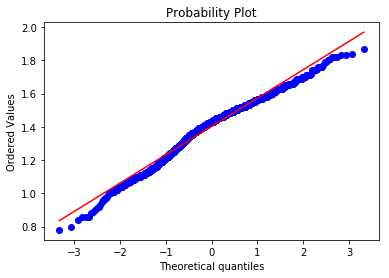

In [12]:
"""Calculate quantiles for a probability plot, and optionally show the plot.

Generates a probability plot of sample data against the quantiles of a specified theoretical distribution (the normal distribution by default). probplot optionally calculates a best-fit line for the data and plots the results using Matplotlib or a given plot function."""
stats.probplot(ERed_data['Ered(V)'],dist="norm",plot=pylab)
pylab.show()

*If our data comes from a normal distribution, we should see all the points sitting on the straight line. The above plot suggests that ERed data is not normally distributed*

**Box plot**

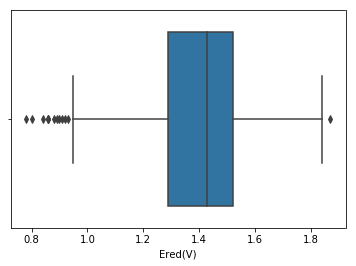

In [13]:
sns.boxplot(x=ERed_data['Ered(V)'])

In [14]:
# If your variable has a normal distribution, we should see the mean and median in the center.
print(f"Reduction potential (ERed) mean={ERed_data['Ered(V)'].mean():0.2f}, median={ERed_data['Ered(V)'].median():0.2f}, mode={ERed_data['Ered(V)'].mode()}")

Reduction potential (ERed) mean=1.40, median=1.43, mode=0    1.46
dtype: float64


The boxplot, histogram and QQ plots suggests that ERed data is not normally distributed

# Statistical Tests of Normality

**Shapiro-Wilk Test**

In [15]:
from scipy.stats import shapiro

#get stats
data=ERed_data['Ered(V)']
stat,p = shapiro(data)

print(f"stat={stat:0.3f} and p={p:0.3f}")
if p > 0.05:
    print("we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian")
else:
    print("we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian")

stat=0.980 and p=0.000
we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian


**D’Agostino’s K-squared test**

This test checks normality of data based on skewness and kurtosis

Skewness is a measure of symmetry.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.

In [16]:
from scipy.stats import normaltest
stat,p = normaltest(data)


print(f"stat={stat:0.3f} and p={p:0.3f}")
if p > 0.05:
    print("we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian")
else:
    print("we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian")

stat=56.140 and p=0.000
we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian


 Anderson-Darling Normality Test

In [17]:
from scipy.stats import anderson
result=anderson(data)
print(f"stat={result.statistic:0.3f}")
for i in range(len(result.critical_values)):
    sig_lev,crit_val = result.significance_level[i],result.critical_values[i]
    if result.statistic < crit_val:
        print(f"Probably normal: {crit_val} critical value at {sig_lev} level of significance")
    else:
        print(f"Probably not normal: {crit_val} critical value at {sig_lev} level of significance")

stat=12.321
Probably not normal: 0.575 critical value at 15.0 level of significance
Probably not normal: 0.654 critical value at 10.0 level of significance
Probably not normal: 0.785 critical value at 5.0 level of significance
Probably not normal: 0.916 critical value at 2.5 level of significance
Probably not normal: 1.089 critical value at 1.0 level of significance


**Jarque–Bera test for Normality**

*this test only works for a large enough number of data samples (>2000)*

In [18]:
# The Jarque-Bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution
from scipy.stats import jarque_bera

stat,p = jarque_bera(data)


print(f"stat={stat:0.3f} and p={p:0.3f}")
if p > 0.05:
    print("we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian")
else:
    print("we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian")


stat=61.519 and p=0.000
we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian


# 5 Molecules with smallest and largest ERed

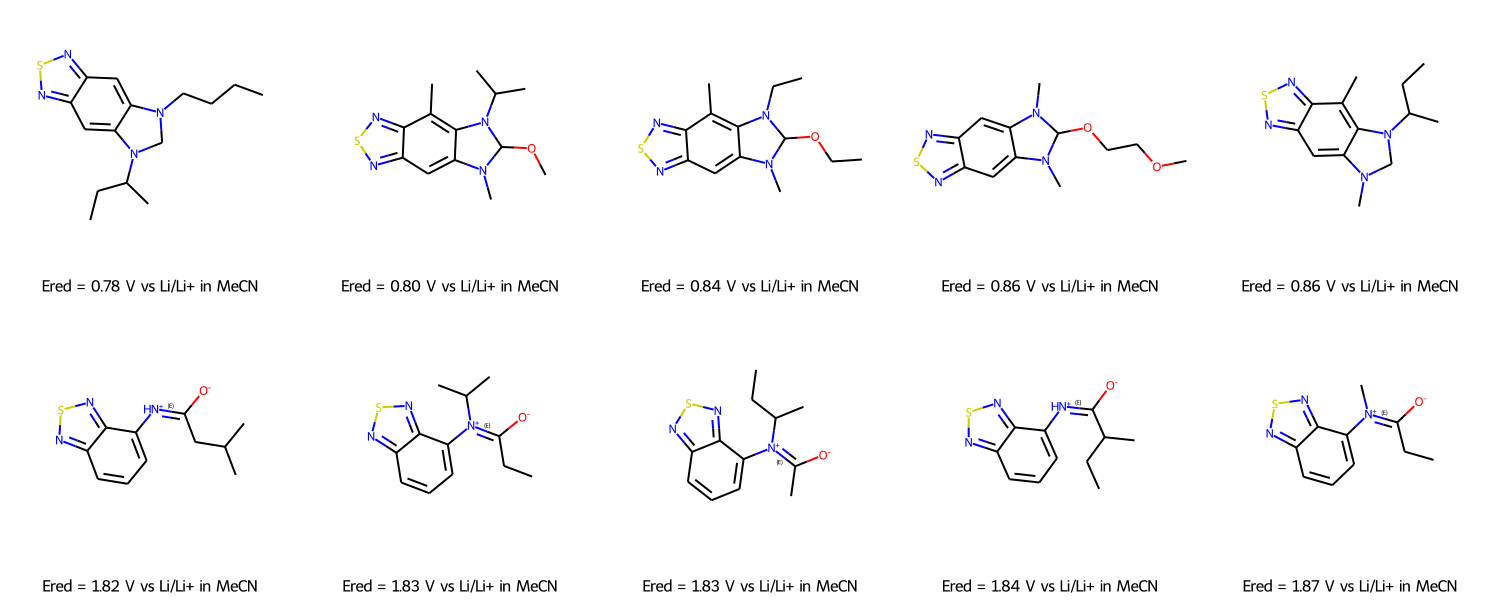

In [19]:
Ered_sorted=ERed_data.sort_values("Ered(V)")
extremes=pd.concat([Ered_sorted[:5],Ered_sorted[-5:]])
mols=[Chem.MolFromSmiles(smi) for smi in extremes["SMILES"]]
# legend_tx=[f"ERed={x.Ered(V):0.2f}" for x in extremes.itertuples()]
legend_tx=[f"Ered = {x:0.2f} V vs Li/Li+ in MeCN" for x in extremes["Ered(V)"]]
dm.to_image(mols=mols,legends=legend_tx,n_cols=5)
